# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,484 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../tesserac

In [ ]:
!pip install pytesseract

In [ ]:
import zipfile

from PIL import Image
import pytesseract
import cv2 as cv
import numpy as np

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# the rest is up to you!

In [ ]:
def read_zip(zip_dir):
    '''Input: zip_dir: zip file directory
       Output: a list of dictionary with the following keys: pillow, faces, text.'''
    # Initialize variables
    return_list = []    
    zip_file = zipfile.PyZipFile(zip_dir, mode = 'r')
    filenames = [filename for filename in zip_file.namelist()]
    count = 0
    
    for file in zip_file.infolist():
        print("Reading file number " + str(count))
        print("  Step 1: Reading an image")
        sub_dict = {}
        # Get file-like object
        file_obj = zip_file.open(file, mode = 'r')
        # open file with Pillow
        pillow_img = Image.open(file_obj)
        # Use numpy array to get gray img
        gray_img = cv.cvtColor(np.array(pillow_img), cv.COLOR_RGB2GRAY)
        # Get bounding boxes (x,y,w,h) from gray_image
        print("  Step 2: Detecting faces")
        faces = face_cascade.detectMultiScale(gray_img, 1.2)
        
        # this list contains all cropped face images (as pillow image object)
        face_imgs = []
        if len(list(faces)) > 0:
            # Crop faces from original images (pillow) using bounding boxes
            for face in faces:
                x, y, w, h = face
                face_cropped = pillow_img.crop((x, y, x+w, y+h))
                face_imgs.append(face_cropped)
        
        # Get a long string from the pillow using pytesseract
        print("  Step 3: Extracting the text")
        text = pytesseract.image_to_string(pillow_img)

        # Insert key-value pairs into the dictionary
        print("  Step 4: Accumulate the result")
        sub_dict['pillow'] = pillow_img
        sub_dict['filename'] = filenames[count]
        sub_dict['faces'] = face_imgs
        sub_dict['text'] = text.lower()
    
        return_list.append(sub_dict)
        count += 1
        
    return return_list
        

In [ ]:
def num_rows(total_pic, col):
    if total_pic % col == 0:
        return total_pic // col
    else:
        return (total_pic // col) + 1

def search(keyword, list_dict):
    # Initialize contact sheet
    width = 500
    height = []
    accum_height = 0
    img_output = []
    # Initialize font
    font = ImageFont.truetype("readonly/fanwood-webfont.ttf", size = 20)
    
    count = 0

    for d in list_dict:
      print("Iterating through number " + str(count))
      
      if keyword.lower() in d['text']:
        # Attach header 
        output_head = "Results found in file " + d['filename']
        bg = Image.new('RGB', (width, 50), color = 'white')
        bg_draw = ImageDraw.Draw(bg)
        bg_draw.text((0, 0), output_head, font = font, fill = "black")
        
        # Save in two lists
        img_output.append(bg)
        height.append(50)    
        accum_height += 50
        
        if len(d['faces']) > 0:
          for i in range(num_rows(len(d['faces']), 5)):
            # Generate canvas for each row
            x_draw, y_draw = 0, 0
            bg = Image.new('RGB', (width, 100), color = 'black')
            for j in range(5):
              if 5*i + j < len(d['faces']):
                # Paste the faces into each block
                img_focus = d['faces'][5*i+j]
                img_focus.thumbnail((100,100))
                bg.paste(img_focus, (x_draw, y_draw))
                x_draw += 100
            # Save results in two lists
            img_output.append(bg)
            height.append(100)
            accum_height += 100
        else:
          # Attach header
          output_exception = "But there were no faces in that file!"
          bg = Image.new('RGB', (500, 50), color = 'white')
          bg_draw = ImageDraw.Draw(bg)
          bg_draw.text((0, 0), output_exception, font = font, fill = "black")
          # Save in two lists
          img_output.append(bg)
          height.append(50)
          accum_height += 50

      count += 1
        
    # Generate new contact sheet to print the output
    contact_sheet = Image.new('RGB', (width, accum_height), color = 'white')
    current_height = 0
    for i in range(len(img_output)):
      contact_sheet.paste(img_output[i], (0, current_height))
      current_height += height[i]

    return contact_sheet


In [ ]:
small_list = read_zip('readonly/small_img.zip')

Reading file number 0
  Step 1: Reading an image
  Step 2: Detecting faces
  Step 3: Extracting the text
  Step 4: Accumulate the result
Reading file number 1
  Step 1: Reading an image
  Step 2: Detecting faces
  Step 3: Extracting the text
  Step 4: Accumulate the result
Reading file number 2
  Step 1: Reading an image
  Step 2: Detecting faces
  Step 3: Extracting the text
  Step 4: Accumulate the result
Reading file number 3
  Step 1: Reading an image
  Step 2: Detecting faces
  Step 3: Extracting the text
  Step 4: Accumulate the result


Iterating through number 0
Iterating through number 1
Iterating through number 2
Iterating through number 3


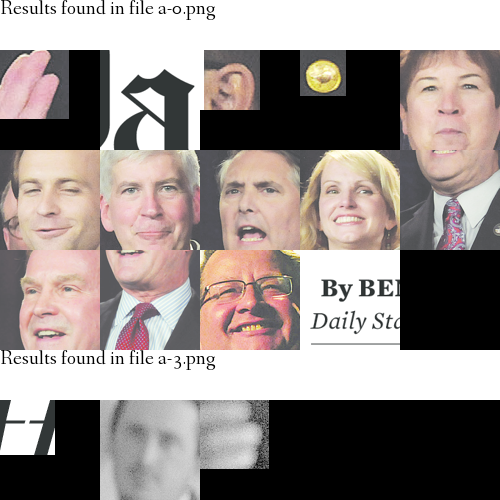

In [ ]:
import PIL
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageChops
display(search("Christopher", small_list))

The codes below are for "experiment" purpose only. These explain how I come up with the above solution.

In [ ]:
import pytesseract
dir(pytesseract)

['Output',
 'TesseractError',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'get_tesseract_version',
 'image_to_boxes',
 'image_to_data',
 'image_to_osd',
 'image_to_pdf_or_hocr',
 'image_to_string',
 'pytesseract']

In [ ]:
help(pytesseract.image_to_string)

Help on function image_to_string in module pytesseract.pytesseract:

image_to_string(image, lang=None, config='', nice=0, output_type='string')
    Returns the result of a Tesseract OCR run on the provided image to string



In [ ]:
from PIL import Image
dir(Image)

['ADAPTIVE',
 'AFFINE',
 'ANTIALIAS',
 'BICUBIC',
 'BILINEAR',
 'BOX',
 'CONTAINER',
 'CUBIC',
 'Callable',
 'DECODERS',
 'DEFAULT_STRATEGY',
 'DecompressionBombError',
 'DecompressionBombWarning',
 'ENCODERS',
 'EXTENSION',
 'EXTENT',
 'FASTOCTREE',
 'FILTERED',
 'FIXED',
 'FLIP_LEFT_RIGHT',
 'FLIP_TOP_BOTTOM',
 'FLOYDSTEINBERG',
 'HAMMING',
 'HAS_PATHLIB',
 'HUFFMAN_ONLY',
 'ID',
 'Image',
 'ImageMode',
 'ImagePointHandler',
 'ImageTransformHandler',
 'LANCZOS',
 'LIBIMAGEQUANT',
 'LINEAR',
 'MAXCOVERAGE',
 'MAX_IMAGE_PIXELS',
 'MEDIANCUT',
 'MESH',
 'MIME',
 'MODES',
 'NEAREST',
 'NONE',
 'NORMAL',
 'OPEN',
 'ORDERED',
 'PERSPECTIVE',
 'PILLOW_VERSION',
 'Path',
 'QUAD',
 'RASTERIZE',
 'RLE',
 'ROTATE_180',
 'ROTATE_270',
 'ROTATE_90',
 'SAVE',
 'SAVE_ALL',
 'SEQUENCE',
 'TRANSPOSE',
 'TRANSVERSE',
 'USE_CFFI_ACCESS',
 'VERSION',
 'WEB',
 '_E',
 '_ENDIAN',
 '_MAPMODES',
 '_MODEINFO',
 '_MODE_CONV',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',


In [ ]:
from PIL import Image
help(Image.open)

Help on function open in module PIL.Image:

open(fp, mode='r')
    Opens and identifies the given image file.
    
    This is a lazy operation; this function identifies the file, but
    the file remains open and the actual image data is not read from
    the file until you try to process the data (or call the
    :py:meth:`~PIL.Image.Image.load` method).  See
    :py:func:`~PIL.Image.new`. See :ref:`file-handling`.
    
    :param fp: A filename (string), pathlib.Path object or a file object.
       The file object must implement :py:meth:`~file.read`,
       :py:meth:`~file.seek`, and :py:meth:`~file.tell` methods,
       and be opened in binary mode.
    :param mode: The mode.  If given, this argument must be "r".
    :returns: An :py:class:`~PIL.Image.Image` object.
    :exception IOError: If the file cannot be found, or the image cannot be
       opened and identified.



In [ ]:
help(Image.Image.thumbnail)

Help on function thumbnail in module PIL.Image:

thumbnail(self, size, resample=3)
    Make this image into a thumbnail.  This method modifies the
    image to contain a thumbnail version of itself, no larger than
    the given size.  This method calculates an appropriate thumbnail
    size to preserve the aspect of the image, calls the
    :py:meth:`~PIL.Image.Image.draft` method to configure the file reader
    (where applicable), and finally resizes the image.
    
    Note that this function modifies the :py:class:`~PIL.Image.Image`
    object in place.  If you need to use the full resolution image as well,
    apply this method to a :py:meth:`~PIL.Image.Image.copy` of the original
    image.
    
    :param size: Requested size.
    :param resample: Optional resampling filter.  This can be one
       of :py:attr:`PIL.Image.NEAREST`, :py:attr:`PIL.Image.BILINEAR`,
       :py:attr:`PIL.Image.BICUBIC`, or :py:attr:`PIL.Image.LANCZOS`.
       If omitted, it defaults to :py:attr:`PIL.I

In [ ]:
import inspect
help(inspect.getsource)

Help on function getsource in module inspect:

getsource(object)
    Return the text of the source code for an object.
    
    The argument may be a module, class, method, function, traceback, frame,
    or code object.  The source code is returned as a single string.  An
    OSError is raised if the source code cannot be retrieved.



In [ ]:
src = inspect.getsource(pytesseract.image_to_string)
print(src)

def image_to_string(image,
                    lang=None,
                    config='',
                    nice=0,
                    output_type=Output.STRING):
    '''
    Returns the result of a Tesseract OCR run on the provided image to string
    '''
    args = [image, 'txt', lang, config, nice]

    return {
        Output.BYTES: lambda: run_and_get_output(*(args + [True])),
        Output.DICT: lambda: {'text': run_and_get_output(*args)},
        Output.STRING: lambda: run_and_get_output(*args),
    }[output_type]()



In [ ]:
import zipfile
help(zipfile.PyZipFile)

Help on class PyZipFile in module zipfile:

class PyZipFile(ZipFile)
 |  PyZipFile(file, mode='r', compression=0, allowZip64=True, optimize=-1)
 |  
 |  Class to create ZIP archives with Python library files and packages.
 |  
 |  Method resolution order:
 |      PyZipFile
 |      ZipFile
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, file, mode='r', compression=0, allowZip64=True, optimize=-1)
 |      Open the ZIP file with mode read 'r', write 'w', exclusive create 'x',
 |      or append 'a'.
 |  
 |  writepy(self, pathname, basename='', filterfunc=None)
 |      Add all files from "pathname" to the ZIP archive.
 |      
 |      If pathname is a package directory, search the directory and
 |      all package subdirectories recursively for all *.py and enter
 |      the modules into the archive.  If pathname is a plain
 |      directory, listdir *.py and enter all modules.  Else, pathname
 |      must be a Python *.py file and the module will be put into

In [ ]:
small_file = zipfile.PyZipFile('readonly/small_img.zip', mode = 'r')

In [ ]:
small_file.infolist()

[<ZipInfo filename='a-0.png' compress_type=deflate external_attr=0x20 file_size=21000053 compress_size=20835185>,
 <ZipInfo filename='a-1.png' compress_type=deflate external_attr=0x20 file_size=22598429 compress_size=20879041>,
 <ZipInfo filename='a-2.png' compress_type=deflate external_attr=0x20 file_size=3650049 compress_size=3320620>,
 <ZipInfo filename='a-3.png' compress_type=deflate external_attr=0x20 file_size=18646538 compress_size=16564827>]

In [ ]:
from PIL import Image
small_file = zipfile.PyZipFile('readonly/small_img.zip', mode = 'r')

In [ ]:
from PIL import Image
for file in small_file.infolist():
    file_obj = small_file.open(file, mode = 'r')
    img = Image.open(file_obj)
    img.convert('RGB')
    display(img)
    

In [ ]:
from PIL import Image
import pytesseract

small_file = zipfile.PyZipFile('readonly/small_img.zip', mode = 'r')
file = list(small_file.infolist())[0]
file_obj = small_file.open(file, mode = 'r')
img = Image.open(file_obj)
text = pytesseract.image_to_string(img)
print(text)

Che Michigan Daily

Ann Arbor, Michigan

Wednesday, November 5, 2014

michigandaily.com

BIG DAY FOR REPUBLICANS

SNYDER EARNS SECOND TERM; G.O.P. TAKES CONTROL OF U.S. SENATE

STATE

EXECUTIVE
GOVERNOR
Rick Snyder (R)

LIEUTENANT
GOVERNOR
Brian Calley (R)

SECRETARY OF
STATE
Ruth Johnson CR)

STATE
JUDICIAL

ATTORNEY GENERAL
Bill Schuette CR)

MICHIGAN
LEGISLATIVE

MICHIGAN STATE
SENATE
Rebekah Warren (D)

MICHIGAN HOUSE
OF REPRESENTATIVES
Jeff Irwin CD)

U.S.
LEGISLATIVE

U.S. SENATE
Gary Peters (D)

U.S. HOUSE OF
REPRESENTATIVES
Debbie Dingell (D)

WASHTENAW
COUNTY

PROBATE COURT
Julia Owdziej (D)

CIRCUIT COURT
Patrick Conlin (D)

ANN ARBOR
MAYOR
Christopher Taylor (D)

CITY COUNCIL

Sumi Kailasapathy (D)
Chuck Warpehoski (D)
Julie Grand (D)
Graydon Kraphol (D)
Kirk Westphal (D)

REGENTS

Too close to call

HI: 51
LO: 30

WEATHER
TOMORROW

 

 

‘alll ai

TOP: Republican Gov. Rick Snyder celebrates after being reelected to a second term at the Renaissance Center in Detroit JAMES CO

In [ ]:
import cv2 as cv
help(cv.CascadeClassifier.detectMultiScale)

Help on method_descriptor:

detectMultiScale(...)
    detectMultiScale(image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]]]]]) -> objects
    .   @brief Detects objects of different sizes in the input image. The detected objects are returned as a list
    .   of rectangles.
    .   
    .   @param image Matrix of the type CV_8U containing an image where objects are detected.
    .   @param objects Vector of rectangles where each rectangle contains the detected object, the
    .   rectangles may be partially outside the original image.
    .   @param scaleFactor Parameter specifying how much the image size is reduced at each image scale.
    .   @param minNeighbors Parameter specifying how many neighbors each candidate rectangle should have
    .   to retain it.
    .   @param flags Parameter with the same meaning for an old cascade as in the function
    .   cvHaarDetectObjects. It is not used for a new cascade.
    .   @param minSize Minimum possible object size. Objects 

In [ ]:
import cv2 as cv
import numpy as np

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

In [ ]:
import zipfile
from PIL import Image
import pytesseract

# Read zip file
small_file = zipfile.PyZipFile('readonly/small_img.zip', mode = 'r')
# Get file in zip file
file = list(small_file.infolist())[0]
# Get file-like object
file_obj = small_file.open(file, mode = 'r')
# Read image with pillow
img = Image.open(file_obj)


<ZipInfo filename='a-0.png' compress_type=deflate external_attr=0x20 file_size=21000053 compress_size=20835185>


In [ ]:
help(zipfile.PyZipFile)

Help on class PyZipFile in module zipfile:

class PyZipFile(ZipFile)
 |  PyZipFile(file, mode='r', compression=0, allowZip64=True, optimize=-1)
 |  
 |  Class to create ZIP archives with Python library files and packages.
 |  
 |  Method resolution order:
 |      PyZipFile
 |      ZipFile
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, file, mode='r', compression=0, allowZip64=True, optimize=-1)
 |      Open the ZIP file with mode read 'r', write 'w', exclusive create 'x',
 |      or append 'a'.
 |  
 |  writepy(self, pathname, basename='', filterfunc=None)
 |      Add all files from "pathname" to the ZIP archive.
 |      
 |      If pathname is a package directory, search the directory and
 |      all package subdirectories recursively for all *.py and enter
 |      the modules into the archive.  If pathname is a plain
 |      directory, listdir *.py and enter all modules.  Else, pathname
 |      must be a Python *.py file and the module will be put into

In [ ]:
import os
img = cv.imread(os.path.join(small_file.filename, file.filename))
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)


error: OpenCV(3.4.5) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
small_file = zipfile.PyZipFile('readonly/small_img.zip', mode = 'r')
file = list(small_file.infolist())[0]
file_obj = small_file.open(file, mode = 'r')
img = Image.open(file_obj)
gray = cv.cvtColor(np.array(img), cv.COLOR_RGB2GRAY)


In [ ]:
pil_img=Image.fromarray(gray,mode="L")
display(pil_img)

In [ ]:
faces = face_cascade.detectMultiScale(gray)
print(faces)

[[3141 1728  283  283]
 [1963 1878  224  224]
 [1153 1997  219  219]
 [1674 2023  216  216]
 [2510  211  149  149]
 [2548 1958  195  195]
 [1370 2092   47   47]
 [ 757 2040   62   62]
 [2860 2092  211  211]
 [1424 2386  199  199]
 [1250 2276  116  116]
 [1320 2354  280  280]
 [2666 3055  291  291]
 [1612 3103  117  117]
 [2711 3290  310  310]
 [ 448 5026   65   65]
 [2410 1251   87   87]
 [1435 5942  113  113]
 [2452 1480   64   64]]


In [ ]:
from PIL import ImageDraw
pil_img=Image.fromarray(gray,mode="L")
drawing = ImageDraw.Draw(pil_img)

for rec in faces:
    x, y, w, h = rec
    drawing.rectangle([x, y, x+w, y+h], outline = "white")
display(pil_img)

In [ ]:
type(data_dict)
first_news = data_dict[0]
print(first_news.keys())

dict_keys(['pillow', 'faces', 'text'])


In [ ]:
display(first_news['pillow'])

In [ ]:
for face in first_news['faces']:
    display(face)

In [ ]:
print(first_news['text'])

Che Michigan Daily

Ann Arbor, Michigan

Wednesday, November 5, 2014

michigandaily.com

BIG DAY FOR REPUBLICANS

SNYDER EARNS SECOND TERM; G.O.P. TAKES CONTROL OF U.S. SENATE

STATE

EXECUTIVE
GOVERNOR
Rick Snyder (R)

LIEUTENANT
GOVERNOR
Brian Calley (R)

SECRETARY OF
STATE
Ruth Johnson CR)

STATE
JUDICIAL

ATTORNEY GENERAL
Bill Schuette CR)

MICHIGAN
LEGISLATIVE

MICHIGAN STATE
SENATE
Rebekah Warren (D)

MICHIGAN HOUSE
OF REPRESENTATIVES
Jeff Irwin CD)

U.S.
LEGISLATIVE

U.S. SENATE
Gary Peters (D)

U.S. HOUSE OF
REPRESENTATIVES
Debbie Dingell (D)

WASHTENAW
COUNTY

PROBATE COURT
Julia Owdziej (D)

CIRCUIT COURT
Patrick Conlin (D)

ANN ARBOR
MAYOR
Christopher Taylor (D)

CITY COUNCIL

Sumi Kailasapathy (D)
Chuck Warpehoski (D)
Julie Grand (D)
Graydon Kraphol (D)
Kirk Westphal (D)

REGENTS

Too close to call

HI: 51
LO: 30

WEATHER
TOMORROW

 

 

‘alll ai

TOP: Republican Gov. Rick Snyder celebrates after being reelected to a second term at the Renaissance Center in Detroit JAMES CO